In [6]:
import itertools
import matplotlib.pyplot as plt
import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from spellchecker import SpellChecker
import tensorflow as tf
from tensorflow.keras.layers import Attention, Bidirectional, Conv1D, Dense, Dropout, Embedding, GlobalAveragePooling1D, GRU, Input, SpatialDropout1D
from tensorflow.keras.models import load_model, Model, Sequential

[nltk_data] Downloading package stopwords to /Users/mymac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mymac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding = 'latin',header=None)
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
lab_to_sentiment = {0: 'Negative', 4: 'Positive'}

def label_decoder(label):
  return lab_to_sentiment[label]

df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


<BarContainer object of 2 artists>

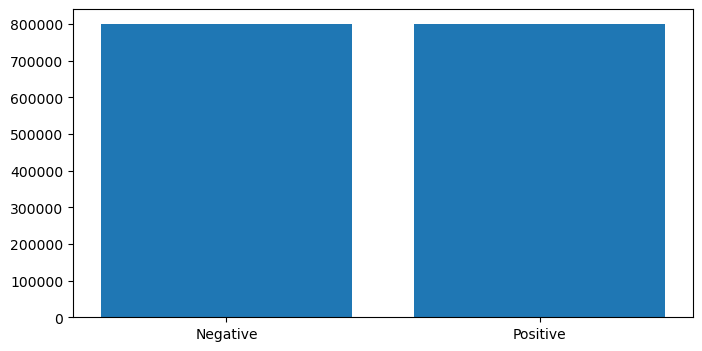

In [3]:
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)

I used lemmatization instead of stemming, tried to separate numbers from text, and originally planned on using spell checking; however, it took too long

In [4]:
TOKENIZE = True

if TOKENIZE:
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    spell = SpellChecker()
    text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
    separate_numbers_re = '(?<=[a-zA-Z])(?=\d)|(?<=\d)(?=[a-zA-Z])'

    def _correct_spelling(tokens):
        corrections = []

        for word in tokens:
            correction = spell.correction(word)
            word_corrected = word if correction is None else correction
            corrections.append(word_corrected)

        return corrections

    def _preprocess(text):
        text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
        text = re.sub(separate_numbers_re, ' ', text)
        
        tokens = []

        for token in text.split():
            if token not in stop_words:
                tokens.append(lemmatizer.lemmatize(token))
        
        # tokens = _correct_spelling(tokens)
        
        return ' '.join(tokens)

    df.text = df.text.apply(lambda x: _preprocess(x))
    df.to_csv('./df_with_tokens.csv')

else:
    df = pd.read_csv('./df_with_tokens.csv')

Normally I like using a train size of 0.7 to 0.75 (seems to be the norm), but I used 0.8 for consistency with the original notebook; I also used the same random state for comparison purposes

In [18]:
TRAIN_SIZE = 0.8
train_data, test_data = train_test_split(df[['text', 'sentiment']], train_size=TRAIN_SIZE, random_state=7)
x_train, y_train, x_test, y_test = np.array(train_data['text']), np.array(train_data['sentiment']), np.array(test_data['text']), np.array(test_data['sentiment'])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1280000,) (1280000,) (320000,) (320000,)


I originally tried using a small bert model (for tokenization and embeddings) but it was still too much for my computer to handle 

In [7]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')

# x_train = tokenizer(list(x_train), truncation=True, padding='max_length', max_length=50, return_tensors='tf')
# x_test = tokenizer(list(x_test), truncation=True, padding='max_length', max_length=50, return_tensors='tf')

# x_train, x_test = x_train['input_ids'], x_test['input_ids']

# print(x_train.shape, x_test.shape)

After trying a few bert models, I decided to just use the original embeddings

In [8]:
embeddings_index = {}

f = open('./glove/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [9]:
LEARN_VECTORIZATION = True

if LEARN_VECTORIZATION:
    vectorizer = tf.keras.layers.TextVectorization(
        output_mode='int',
        output_sequence_length=50
    )
    vectorizer.adapt(df['text'])
    vectorizer_model = Sequential([Input(shape=(1,), dtype=tf.string), vectorizer])
    vectorizer_model.save('./text_vectorization_layer')

else:
    vectorizer = load_model('./text_vectorization_layer').layers[0]

2024-09-10 09:05:41.887200: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-10 09:05:41.887373: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-09-10 09:05:41.887381: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-09-10 09:05:41.887794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-10 09:05:41.887874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-10 09:05:42.089551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-09-10 09:05:42.090646

INFO:tensorflow:Assets written to: ./text_vectorization_layer/assets


INFO:tensorflow:Assets written to: ./text_vectorization_layer/assets


In [15]:
vocab = vectorizer.get_vocabulary()
vocab_size = vectorizer.vocabulary_size()

vocab_size

310299

In [19]:
x_train, x_test = vectorizer(x_train.astype(str)), vectorizer(x_test.astype(str))

print(x_train.shape, x_test.shape)

(1280000, 50) (320000, 50)


In [20]:
encoder = LabelEncoder()
encoder.fit(list(y_train))

y_train = encoder.transform(list(y_train))
y_test = encoder.transform(list(y_test))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(y_train.shape, y_test.shape)

(1280000, 1) (320000, 1)


In [21]:
LR = 1e-3
BATCH_SIZE = 512
EPOCHS = 10

In [22]:
embedding_matrix = np.zeros((vocab_size, 300))

for i, word in enumerate(vocab):
  embedding_vector = embeddings_index.get(word)
  
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

As I mentioned previously, I was originally planning to use a small version of bert in my model for embeddings; however, it was going to take too long to run (about 2 hours per epoch)

In [15]:
# distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased-distilled-squad')

# def build_model():
#     inputs = tf.keras.Input(shape=(50,), dtype=tf.int32)
#     embeddings = distilbert_model(inputs).last_hidden_state
#     spatial_dropout = SpatialDropout1D(0.2)(embeddings)
#     gru_output = Bidirectional(GRU(64, return_sequences=True))(spatial_dropout)
#     attention = Attention(dropout=0.2)([gru_output, gru_output])
#     pooled_output = GlobalAveragePooling1D()(attention)
#     dense_1 = tf.keras.layers.Dense(512, activation='relu')(pooled_output)
#     dropout = tf.keras.layers.Dropout(0.5)(dense_1)
#     dense_2 = tf.keras.layers.Dense(512, activation='relu')(dropout)
#     outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)
#     model = tf.keras.Model(inputs, outputs)
    
#     return model

Despite not using bert, I still made a few changes to the model: I used a max text length of 50 tokens (to allow for longer tweets), a GRU instead of an LSTM, an attention layer after the GRU, and I reduced the final dropout rate to 0.2 (the original 0.5 seemed like too much)

In [23]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=50, trainable=False)

def build_model():
    inputs = Input(shape=(50,), dtype=tf.int32)
    embeddings = embedding_layer(inputs)
    spatial_dropout = SpatialDropout1D(0.2)(embeddings)
    conv = Conv1D(64, 5, activation='relu')(spatial_dropout)
    gru_output = Bidirectional(GRU(64, return_sequences=True))(conv)
    attention = Attention(dropout=0.2)([gru_output, gru_output])
    pooled_output = GlobalAveragePooling1D()(attention)
    dense_1 = Dense(512, activation='relu')(pooled_output)
    dropout = Dropout(0.2)(dense_1)
    dense_2 = Dense(512, activation='relu')(dropout)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    model = Model(inputs, outputs)
    
    return model

In [24]:
model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/10


W0000 00:00:1725981730.222433       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-09-10 09:22:10.229483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2499/2500 [============================>.] - ETA: 0s - loss: 0.5075 - accuracy: 0.7476

W0000 00:00:1725981825.646985       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-09-10 09:23:45.648724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2500/2500 [==============================] - 105s 41ms/step - loss: 0.5075 - accuracy: 0.7476 - val_loss: 0.4782 - val_accuracy: 0.7682
Epoch 2/10
2500/2500 [==============================] - 103s 41ms/step - loss: 0.4779 - accuracy: 0.7682 - val_loss: 0.4669 - val_accuracy: 0.7761
Epoch 3/10
2500/2500 [==============================] - 104s 42ms/step - loss: 0.4677 - accuracy: 0.7748 - val_loss: 0.4637 - val_accuracy: 0.7776
Epoch 4/10
2500/2500 [==============================] - 103s 41ms/step - loss: 0.4616 - accuracy: 0.7792 - val_loss: 0.4607 - val_accuracy: 0.7801
Epoch 5/10
2500/2500 [==============================] - 104s 42ms/step - loss: 0.4566 - accuracy: 0.7820 - val_loss: 0.4607 - val_accuracy: 0.7808
Epoch 6/10
2500/2500 [==============================] - 103s 41ms/step - loss: 0.4530 - accuracy: 0.7842 - val_loss: 0.4574 - val_accuracy: 0.7815
Epoch 7/10
2500/2500 [==============================] - 104s 42ms/step - loss: 0.4499 - accuracy: 0.7862 - val_loss: 0.4562 - val

The new performance is definitely better than the original (at least when I ran the original on my laptop)

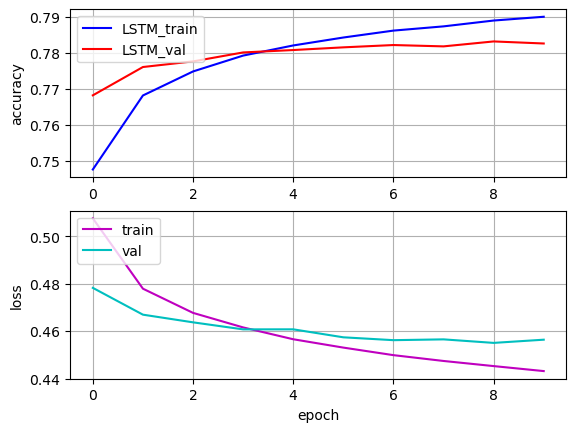

In [29]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_ylabel('accuracy')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')
at.grid()

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
al.grid()

plt.show()

In [30]:
def decode_sentiment(score):
    return 'Positive' if score > 0.5 else 'Negative'

scores = model.predict(x_test, verbose=1, batch_size=BATCH_SIZE)
y_pred_1d = [decode_sentiment(score) for score in scores]

  1/625 [..............................] - ETA: 4:02

W0000 00:00:1725982843.282844       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-09-10 09:40:43.283876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


625/625 [==============================] - 9s 13ms/step


In [31]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

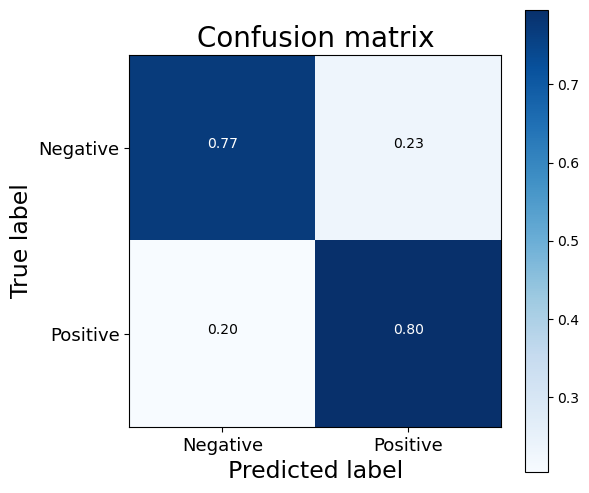

In [32]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [33]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    160542
    Positive       0.77      0.80      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



The best test set accuracy from the model/process introduced in the original notebook was about 0.69.  This was somewhat similar to the results I saw on kaggle, but there appear to be some minor differences; I'm guessing that my version of tensorflow and/or other packages might be the cause of these discrepancies.  Regardless, my goal was to beat the original model.

I first began with improving the text preprocessing phase.  I used lemmatization instead of stemming, because I read that lemmatization is typically more effective than stemming (but takes longer to run).  I also noticed there were several messages with text surrounded by numbers; to combat this, I used regex to separate the two.  Finally, I thought it might be effective to add spell correction (as people often misspell words).  However, this took very long to run (after about 2 hours my preprocessing code was still running), so I decided to discard it.

For the train and test sets, I used a train size of 0.8 and the same random state from the original notebook (for comparison purposes).  I normally like to use a train size of 0.7 or 0.75 (because that seems to be common practice), but, again, I wanted to use the exact same sets from the original notebook for comparison.

I was hoping to use a small bert model from Hugging Face for tokenization and embeddings, but even the smallest model I found took too long to run on my computer (more on this in the next paragraph).  Instead, I ended up using TensorFlow's text vectorization layer.  The tokenizer from the original notebook has been deprecated, so I figured it would be better to at least use something more up-to-date.

As was mentioned previously, I wanted to use a small bert model as an embedding layer in my TensorFlow model.  However, when I set everything up, each training epoch was estimated to take about 2 hours.  So, for the word embeddings, I ended up using the same ones from the original notebook.  However, I did make a few changes to the model.  First, I used a maximum sequence length of 50 instead of 30 (to allow for longer tweets).  Second, I used a GRU instead of an LSTM.  Third, I used a simple attention layer after the GRU; this obviously isn't a transformer, but at least is a step in the right direction.  Finally, I reduced the final dropout layer rate to 0.2 (the original 0.5 seemed like too much).

With these changes, one can hopefully see that the training process was smoother (on the training and validation sets, and in terms of loss and accuracy) and the test set results were better in nearly every category.  Specifically, my test set accuracy, precision scores, F1 scores, and recall scores (except in the negative case) were better.  Their recall score in the negative case was better (0.87 compared to my 0.77).